# Starting in ML with with Python and the Titanic dataset 

In [1]:
import random
import pandas as pd

from mlbox.prediction import *
import matplotlib.pyplot as plt
from mlbox.optimisation import *
from mlbox.preprocessing import *
from sklearn import preprocessing
from pandas_profiling import ProfileReport
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
%matplotlib inline

## Auto EDA

In [2]:
df = pd.read_csv('./data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
eda_report = ProfileReport(df)
eda_report

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Some variables relationship exploration

Text(0, 0.5, '% Survived')

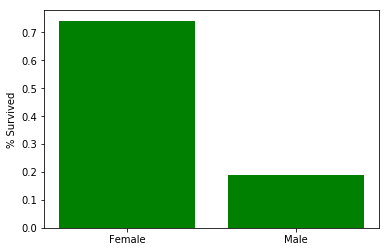

In [4]:
fig, ax = plt.subplots(figsize=(6,4))
gender_count = df['Sex'].value_counts(sort=False)
s_count = df.loc[df['Survived'] == 1, ['Sex']].value_counts(sort=False) 
ns_count = df.loc[df['Survived'] == 0, ['Sex']].value_counts(sort=False) 
ax.bar('Female', s_count['female']/gender_count['female'], color='green')
ax.bar('Male', s_count['male']/gender_count['male'], color='green')
ax.set_ylabel('% Survived')

Text(0, 0.5, '% Survived')

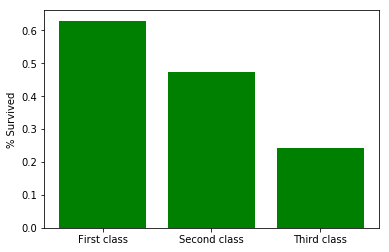

In [5]:
fig, ax = plt.subplots(figsize=(6,4))
pclass_count = df['Pclass'].value_counts(sort=False)
s_count = df.loc[df['Survived'] == 1, ['Pclass']].value_counts(sort=False) 
ns_count = df.loc[df['Survived'] == 0, ['Pclass']].value_counts(sort=False) 
ax.bar('First class', s_count.iloc[0]/pclass_count.iloc[0], color='green')
ax.bar('Second class', s_count.iloc[1]/pclass_count.iloc[1], color='green')
ax.bar('Third class', s_count.iloc[2]/pclass_count.iloc[2], color='green')
ax.set_ylabel('% Survived')

Text(0, 0.5, '% Survived')

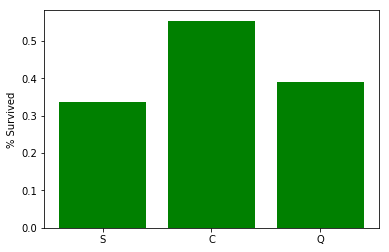

In [6]:
fig, ax = plt.subplots(figsize=(6,4))
embarked_count = df['Embarked'].value_counts(sort=False)
s_count = df.loc[df['Survived'] == 1, ['Embarked']].value_counts(sort=False) 
ns_count = df.loc[df['Survived'] == 0, ['Embarked']].value_counts(sort=False) 
ax.bar('S', s_count['S']/embarked_count['S'], color='green')
ax.bar('C', s_count['C']/embarked_count['C'], color='green')
ax.bar('Q', s_count['Q']/embarked_count['Q'], color='green')
ax.set_ylabel('% Survived')

## Feature engineering

In [7]:
df['Sex'] = preprocessing.LabelEncoder().fit_transform(df['Sex'])
df['Embarked'] = preprocessing.LabelEncoder().fit_transform(df['Embarked'])
df[['Sex','Embarked']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Sex       891 non-null    int64
 1   Embarked  891 non-null    int64
dtypes: int64(2)
memory usage: 14.0 KB


## Baseline model

In [8]:
X = df[['Sex','Pclass','Embarked']]
y = df['Survived']
clf = DecisionTreeClassifier(random_state=42)
scores = cross_val_score(clf, X, y, cv=5)
print("Mean accuracy for 5 folds", scores)

Mean accuracy for 5 folds [0.80446927 0.82022472 0.83146067 0.78651685 0.81460674]


In [9]:
#fit the model with all train data
clf.fit(X,y)

#Load and transform the test data
df_test = pd.read_csv('./data/test.csv')
df_test['Sex'] = preprocessing.LabelEncoder().fit_transform(df_test['Sex'])
df_test['Embarked'] = preprocessing.LabelEncoder().fit_transform(df_test['Embarked'])

#Predict over the test dataframe
predictions = clf.predict(df_test[['Sex','Pclass','Embarked']])

#prepares a dataframe to be submitted
df_submission = pd.DataFrame({'PassengerId':df_test['PassengerId'], 'Survived':predictions})
#data types must be exactly the same as the training data
df_submission.Survived = df_submission.Survived.astype(int)
#only saves the two columns into the submission csv file
df_submission.to_csv( './results/baseline_submission.csv',index=False )

## AutoML

In [16]:
paths = ["./data/train.csv","./data/test.csv"]
target_name = "Survived"
#MLBox reader
rd = Reader(sep = ",")
df_mlbox = rd.train_test_split(paths, target_name)


reading csv : train.csv ...
cleaning data ...
CPU time: 4.414753198623657 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.04788780212402344 seconds

> Number of common features : 11

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 5
> Number of numerical features: 6
> Number of training samples : 891
> Number of test samples : 418

> Top sparse features (% missing values on train set):
Cabin       77.1
Age         19.9
Embarked     0.2
dtype: float64

> Task : classification
0.0    549
1.0    342
Name: Survived, dtype: int64

encoding target ...


In [18]:
dft = Drift_thresholder()
df = dft.fit_transform(df_mlbox)   #removing non-stable features (like ID,...)


computing drifts ...
CPU time: 0.27789878845214844 seconds

> Top 10 drifts

('PassengerId', 0.9976076555023923)
('Name', 0.9907209289823127)
('Ticket', 0.6627713491463281)
('Cabin', 0.18140594929198794)
('Embarked', 0.0790020812324328)
('Age', 0.056642682550217316)
('Pclass', 0.031607250008015786)
('Fare', 0.01938624737615946)
('Sex', 0.01122793918934395)
('SibSp', 0.0063526166561755915)

> Deleted variables : ['Name', 'PassengerId', 'Ticket']
> Drift coefficients dumped into directory : save


In [19]:
opt = Optimiser(scoring = "accuracy", n_folds = 5)

/home/nickman/.virtualenvs/titanic/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")


In [20]:
space = {
        'est__n_estimators':{"search":"choice","space":[150]},    
        'est__colsample_bytree':{"search":"uniform","space":[0.8,0.95]},
        'est__subsample':{"search":"uniform","space":[0.8,0.95]},
        'est__max_depth':{"search":"choice","space":[5,6,7,8,9]},
        'est__learning_rate':{"search":"choice","space":[0.07]} 
        }
params = opt.optimise(space, df,15)

##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}        
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.8747286721929959, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.902247173093288, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : accuracy = 0.8327976900382902            
VARIANCE : 0.016897571274943367 (fold 1 = 0.8100558659217877, fold 2 = 0.8595505617977528, fold 3 = 0.8258426966292135, fold 4 = 0.8258426966292135, 


fitting the pipeline ...
CPU time: 0.07694888114929199 seconds


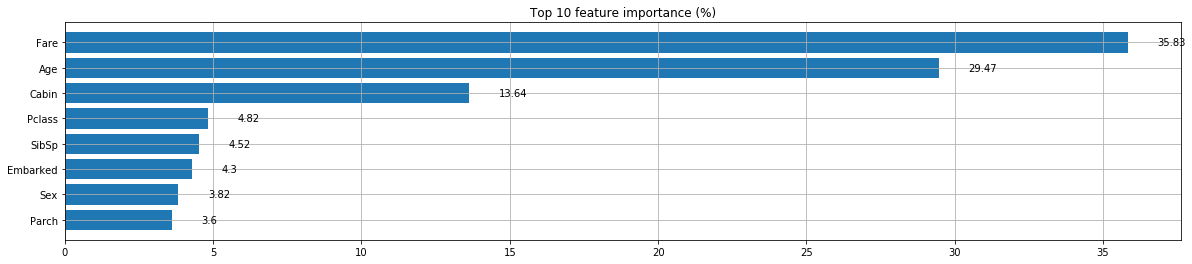


> Feature importances dumped into directory : save

predicting ...
CPU time: 0.05350804328918457 seconds

> Overview on predictions : 

        0.0       1.0  Survived_predicted
0  0.940753  0.059247                   0
1  0.889897  0.110103                   0
2  0.837877  0.162123                   0
3  0.832360  0.167640                   0
4  0.576438  0.423562                   0
5  0.723604  0.276396                   0
6  0.431614  0.568386                   1
7  0.856182  0.143818                   0
8  0.145416  0.854584                   1
9  0.957879  0.042121                   0

dumping predictions into directory : save ...


In [21]:
prd = Predictor()
prd.fit_predict(params, df)

In [23]:
submit = pd.read_csv("./results/baseline_submission.csv",sep=',')
preds = pd.read_csv("./save/"+target_name+"_predictions.csv")
submit[target_name] =  preds[target_name+"_predicted"].values
submit.to_csv("./results/mlbox.csv", index=False)